In [1]:
import numpy as np
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt

n = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,n+1)
delt = T/n
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt   

In [2]:
v_f = [1,1]       # desired final velocity of the leader
r_formation = 1    # the radius of the formation circle
K = 37   # number of drones

np.random.seed(786)
p_0 = np.random.randn(2,K)*2    # initial positions
v_0 = np.random.randn(2,K) # initial velocities
s_des = np.zeros(4*K-2)
x = np.zeros((4*K,n+1))
F = np.zeros((4*K-2,4*K))

C = np.zeros((4*K,4*K))
D = np.zeros((4*K,2*K))   
for i in range(K):
  C[4*i:4*(i+1),4*i:4*(i+1)] = A 
  D[4*i:4*(i+1),2*i:2*(i+1)] = B
  
for i in range(K):
  x[4*i:4*i+2,0] = p_0[:,i]
  x[4*i+2:4*i+4,0] = v_0[:,i]

F[-1,3],F[-2,2] = v_f
for i in range(4*(K-1)):
  if i<2*(K-1):                    # fill position component of x axis  
    if i%2 == 0:                       
      F[i,0]= -1                   
      F[i,2*i+4] = 1             
    else:                          # fill position component of y axis
      F[i,1] = -1                  
      F[i,2*i+3] = 1 
  else:
    if i%2 == 0:                   # fill velocity component of x axis
      F[i,2] = -1
      F[i,2*(i-2*(K-1))+6] = 1
    else:
      F[i,3] = -1                  # fill velocity component of y axis
      F[i,2*(i-2*(K-1))+5] = 1

s_des[-1],s_des[-2] = 1,1
for i in range(2*K-2):
  if i < K-1:
    s_des[2*i:2*(i+1)] = [r_formation*np.sin(np.pi*2*i/(K-1)), r_formation*np.cos(np.pi*2*i/(K-1))]
  else:
    s_des[2*i:2*(i+1)] = [0,0]
  
G = np.zeros((4*K,2*K*n))
for i in range(n):
  G[:, 2*K*i:2*K*(i+1)] = np.linalg.matrix_power(C,max(0,n-i-1))@D

u_vec = sla.lsqr(F@G,s_des - F@np.linalg.matrix_power(C,n)@x[:,0].T)[0]
u_opt = u_vec.reshape(n,2*K).T
  
for t in range(n):
  x[:,t+1] = C.dot(x[:,t]) + D.dot(u_opt[:,t])

Text(0, 0.5, '$y$ position')

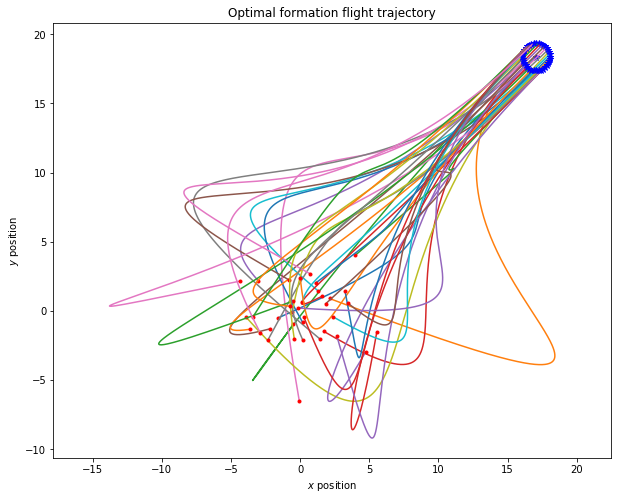

In [3]:
plt.figure(figsize=(10,8))

for i in range(K):
  plt.plot(x[4*i,:],x[4*i+1,:])
  plt.plot(x[4*i,1000], x[4*i+1,1000], 'b*', markersize=7) 
  plt.plot(x[4*i,0], x[4*i+1,0], 'ro', markersize=3, label='Initial position')
plt.title('Optimal formation flight trajectory')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
